In [ ]:
# pip install wordcloud
# pip install textblob
!pip install emoji
!pip install fasttext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path="For the files folder"

In [ ]:
# Python Libs
import re
import csv
import os
import datetime
import emoji
import pandas as pd
import numpy as np
import time

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, plot_precision_recall_curve, average_precision_score, classification_report, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import metrics
from gensim.models import KeyedVectors
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.utils import plot_model

# Sentiment & Text analysis libs
from wordcloud import WordCloud
from textblob import TextBlob

# plotting and math libs
from tqdm import tqdm
import matplotlib.pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Twitter Liba
import tweepy
from tweepy import OAuthHandler
import operator 
import json
from collections import Counter
from collections import defaultdict
import datetime as datetime
import requests

import fasttext
import fasttext.util

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Classification Models

### **Loading the data**

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 80_000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a phrase to use
#define a batch size
batch_size = 64

In [ ]:
# loading the data
users_tweets_path_r = path + '/Right_Users_Tweets.csv'
users_tweets_path_l = path + '/Left_Users_Tweets.csv'
df_r = pd.read_csv(users_tweets_path_r)
df_l = pd.read_csv(users_tweets_path_l)
df = df_r.append(df_l, ignore_index=True)

In [ ]:
import string
 
punctuation = list(string.punctuation)
punctuation.remove('@')
punctuation = ''.join(punctuation)
print(punctuation)
def remove_punctuations(sentence):
    try:
        new_s = ""
        for w in sentence.split(" "):
            new_s += w.strip(punctuation) + " "
        return new_s
    except:
        return sentence

!"#$%&'()*+,-./:;<=>?[\]^_`{|}~


In [ ]:
df['text'] = df['text'].apply(remove_punctuations)
df['class'] = df['class'].astype(np.int)

In [ ]:
# Balancing the records amount
to_remove = np.random.choice(df[df['class']==0].index,size=185_096,replace=False)
df = df.drop(to_remove)

1    356003
0    356003
Name: class, dtype: int64


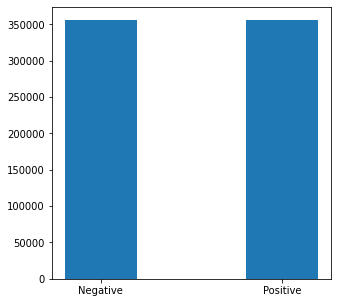

In [ ]:
print(df['class'].value_counts())
_ = plt.figure(figsize=(5,5))
_ = plt.bar(x=['Negative', 'Positive'], height=df['class'].value_counts(), width=0.4)
plt.show()

#### Plotting most frequent terms in the tweets collection


##### Hebrew Stop Words

In [ ]:
hebrew_stopwords = ['אני',
'את',
'אתה',
'אנחנו',
'אתן',
'אתם',
'הם',
'הן',
'היא',
'הוא',
'שלי',
'שלו',
'שלך',
'שלה',
'שלנו',
'שלכם',
'שלכן',
'שלהם',
'שלהן',
'לי',
'לו',
'לה',
'לנו',
'לכם',
'לכן',
'להם',
'להן',
'אותה',
'אותו',
'זה',
'זאת',
'אלה',
'אלו',
'תחת',
'מתחת',
'מעל',
'בין',
'עם',
'עד',
'נגר',
'על',
'אל',
'מול',
'של',
'אצל',
'כמו',
'אחר',
'אותו',
'בלי',
'לפני',
'אחרי',
'מאחורי',
'עלי',
'עליו',
'עליה',
'עליך',
'עלינו',
'עליכם',
'לעיכן',
'עליהם',
'עליהן',
'כל',
'כולם',
'כולן',
'כך',
'ככה',
'כזה',
'זה',
'זות',
'אותי',
'אותה',
'אותם',
'אותך',
'אותו',
'אותן',
'אותנו',
'ואת',
'את',
'אתכם',
'אתכן',
'איתי',
'איתו',
'איתך',
'איתה',
'איתם',
'איתן',
'איתנו',
'איתכם',
'איתכן',
'יהיה',
'תהיה',
'היתי',
'היתה',
'היה',
'להיות',
'עצמי',
'עצמו',
'עצמה',
'עצמם',
'עצמן',
'עצמנו',
'עצמהם',
'עצמהן',
'מי',
'מה',
'איפה',
'היכן',
'במקום שבו',
'אם',
'לאן',
'למקום שבו',
'מקום בו',
'איזה',
'מהיכן',
'איך',
'כיצד',
'באיזו מידה',
'מתי',
'בשעה ש',
'כאשר',
'כש',
'למרות',
'לפני',
'אחרי',
'מאיזו סיבה',
'הסיבה שבגללה',
'למה',
'מדוע',
'לאיזו תכלית',
'כי',
'יש',
'אין',
'אך',
'מנין',
'מאין',
'מאיפה',
'יכל',
'יכלה',
'יכלו',
'יכול',
'יכולה',
'יכולים',
'יכולות',
'יוכלו',
'יוכל',
'מסוגל',
'לא',
'רק',
'אולי',
'אין',
'לאו',
'אי',
'כלל',
'נגד',
'אם',
'עם',
'אל',
'אלה',
'אלו',
'אף',
'על',
'מעל',
'מתחת',
'מצד',
'בשביל',
'לבין',
'באמצע',
'בתוך',
'דרך',
'מבעד',
'באמצעות',
'למעלה',
'למטה',
'מחוץ',
'מן',
'לעבר',
'מכאן',
'כאן',
'הנה',
'הרי',
'פה',
'שם',
'אך',
'ברם',
'שוב',
'אבל',
'מבלי',
'בלי',
'מלבד',
'רק',
'בגלל',
'מכיוון',
'עד',
'אשר',
'ואילו',
'למרות',
'אס',
'כמו',
'כפי',
'אז',
'אחרי',
'כן',
'לכן',
'לפיכך',
'מאד',
'עז',
'מעט',
'מעטים',
'במידה',
'שוב',
'יותר',
'מדי',
'גם',
'כן',
'נו',
'אחר',
'אחרת',
'אחרים',
'אחרות',
'אשר',
'או', 'rt']

##### Dividing and Arranging the data according to the user's political stance

In [ ]:
# Dividing the data according to the user's political stance
word_tweets_dict = dict()
word_counter = 0
for tweet in df['text'].values:
  try:
    for word in tweet.split(' '):
      if not word in word_tweets_dict.keys() and word not in hebrew_stopwords:
        word_tweets_dict[word] = word_counter
        word_counter += 1
  except:
    continue

# Count the terms 
count_vectorizer = CountVectorizer(vocabulary=word_tweets_dict, min_df=1)
terms_arr = count_vectorizer.transform((df['text'].values).astype('U'))

positive_indexes = df.index[df['class'] == 1].tolist()
negative_indexes = df.index[df['class'] == 0].tolist()

terms_arr_pos = terms_arr[positive_indexes]
terms_arr_neg = terms_arr[negative_indexes]

print("All terms that belongs to left wing: " , terms_arr_pos.shape)
print("All terms that belongs to right wing: ", terms_arr_neg.shape)

tf_pos_terms = np.array(terms_arr_pos.sum(axis=0))[0]
tf_neg_terms = np.array(terms_arr_neg.sum(axis=0))[0]



All terms that belongs to left wing:  (356003, 490992)
All terms that belongs to right wing:  (541099, 490992)


In [ ]:
terms_names = count_vectorizer.get_feature_names()
print("Number of unique terms in the all tweets: ", len(terms_names))
print("Terms array shape: ", terms_arr.shape)

# Retrieving the indexes of top 10 term frequency of positive&negative sentiment
top_pos_vector_indexes = list(reversed(tf_pos_terms.argsort()[-10:,]))
top_neg_vector_indexes = list(reversed(tf_neg_terms.argsort()[-10:,]))

# Retrieving the terms associated with their indexes
top_pos_vector_terms = [[terms_names[index], tf_pos_terms[index]] for index in top_pos_vector_indexes]
top_neg_vector_terms = [[terms_names[index], tf_neg_terms[index]] for index in top_neg_vector_indexes]

df_pos_top10_terms = pd.DataFrame({'Left Wing Terms': [term[0] for term in top_pos_vector_terms], 'Frequency': [term[1] for term in top_pos_vector_terms]})
df_neg_top10_terms = pd.DataFrame({'Right Wing Terms': [term[0] for term in top_neg_vector_terms], 'Frequency': [term[1] for term in top_neg_vector_terms]})

Number of unique terms in the all tweets:  490992
Terms array shape:  (897102, 490992)


In [ ]:
# Helper JS function to display side by side in Jupyter notebook 
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

print("Most popular terms for right and left wings tweets:")
display_side_by_side(df_pos_top10_terms, df_neg_top10_terms)

Most popular terms for right and left wings tweets:


,Left Wing Terms,Frequency
0,נתניהו,21104
1,ישראל,13215
2,שלא,12807
3,כבר,11914
4,עוד,11812
5,הזה,11617
6,אחד,11133
7,לך,10874
8,ולא,10670
9,שהוא,9755


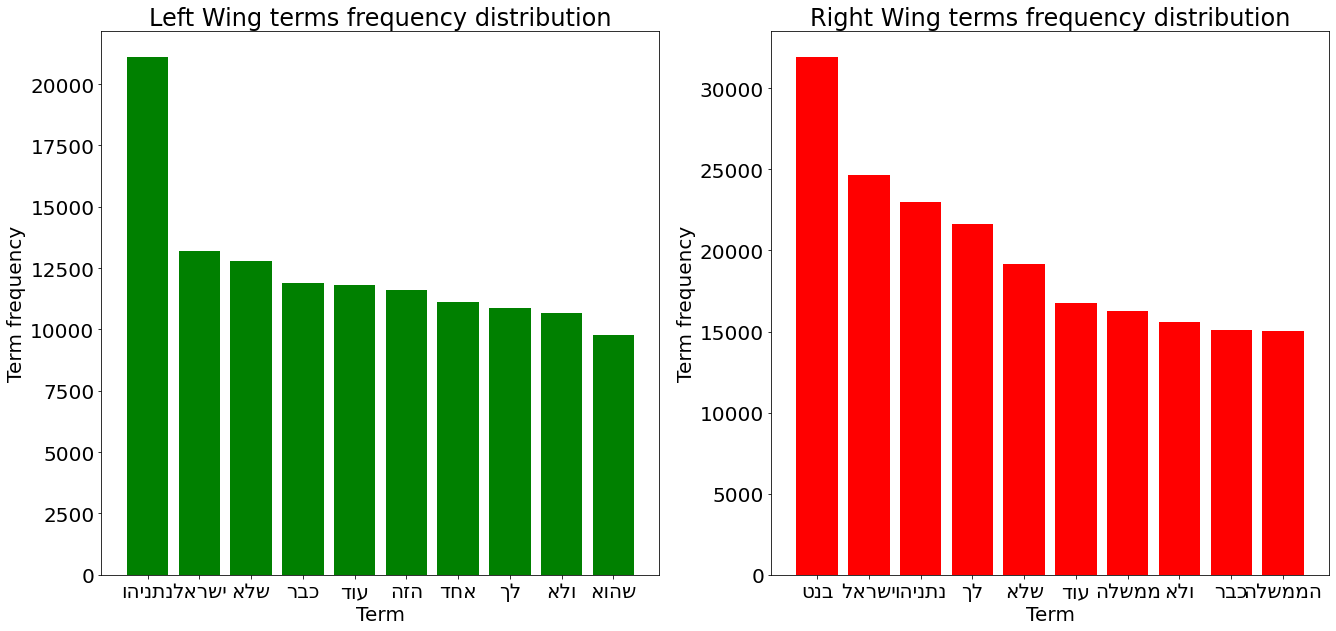

In [ ]:
# Lib for displaying Hewbrew text from left-to-right
!pip install python-bidi
from bidi import algorithm as bidialg

def plot_bar_top10_terms(pos: pd.DataFrame, neg: pd.DataFrame, rotation='horizontal'): 
  """
  Plotting the 10 top freqeunt terms  in the data
  """
  pos['Left Wing Terms'] = [bidialg.get_display(x) for x in pos['Left Wing Terms']]
  neg['Right Wing Terms'] = [bidialg.get_display(x) for x in neg['Right Wing Terms']]

  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,10))

  ax1.bar(pos['Left Wing Terms'], pos['Frequency'], color='g')
  ax1.set_title('Left Wing terms frequency distribution')
  ax1.set_xlabel('Term')
  ax1.set_xticklabels(pos['Left Wing Terms'], rotation=rotation)
  ax1.set_ylabel('Term frequency')

  ax2.bar(neg['Right Wing Terms'], neg['Frequency'], color='r')
  ax2.set_title('Right Wing terms frequency distribution')
  ax2.set_xlabel('Term')
  ax2.set_xticklabels(neg['Right Wing Terms'], rotation=rotation)
  ax2.set_ylabel('Term frequency')
  plt.show()

plot_bar_top10_terms(df_pos_top10_terms, df_neg_top10_terms)

### **Naive Model classification**

**Dividing the data into train and test sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.2, random_state=42)

In [ ]:
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((717681,), (179421,), (717681,), (179421,))

<b> Preparing the data - TfIdf, n-gram </b>

In [ ]:
def draw_plots(models, model_descriptions, scores, train_times, val_times):
    
    indices = np.arange(len(models))

    training_time = np.array(train_times) / np.max(train_times)+0.05
    test_time = np.array(val_times) / np.max(val_times)
    
    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, scores, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",color='c')
    plt.barh(indices + .6, test_time, .2, label="validation time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, model_descriptions):
        plt.text(-.3, i, c)

    plt.show()

def optimize_models(models, vectorizer):
    for model in models:
        clf = Pipeline([('vect', vectorizer),('clf', model)])
        
        if str(model).split('(')[0]== 'LinearSVC': 
            parameters =  {'vect__max_df': (0.2,0.5), 'vect__ngram_range': ((1,2),(1,3)),'clf__max_iter': (4000,5000)}
            gs_clf = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
        
        if str(model).split('(')[0]== 'Perceptron': 
            parameters =  {'vect__max_df': (0.2,0.5), 'vect__ngram_range': ((1,2),(1,3)),'clf__validation_fraction':(0.1,0.5)}
            gs_clf = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
        
        if str(model).split('(')[0]== 'MultinomialNB': 
            parameters =  {'vect__max_df': (0.2,0.5), 'vect__ngram_range': ((1,2),(1,3)),'clf__alpha': (0.01,1.0)}
            gs_clf = GridSearchCV(clf, parameters, n_jobs=1)
        
        gs_clf = gs_clf.fit(X_train.astype('U'), y_train)
        
        print('For ', str(model).split('(')[0], 'classifier - ')
        print('Best score: ',gs_clf.best_score_, ' Best params: ',gs_clf.best_params_)
        print('_'*100)


def fit_models(X, X_val, y_val, vectorizer, models, with_train):
    scores = []
    train_times = []
    val_times = []
    model_descriptions = []
    i = 0
    for model in models:
        train_time = 0
        if with_train:
            t0_train = time.time()
            history = model.fit(X[i], y_train)
            train_time = time.time()-t0_train
        t0_val = time.time()
        predictions = model.predict(vectorizer[i].transform(X_val.astype('U')))
        val_time = time.time()-t0_val
        train_times.append(train_time)
        val_times.append(val_time)
        model_descriptions.append(str(model).split('(')[0])
        scores.append(accuracy_score(y_val, predictions))
        
#         if print_details:
        print(str(model).split('(')[0])
        print(model.get_params())
        print('Score: ', accuracy_score(y_val, predictions))
        print('Training time: ', train_time)
        print('Validation time: ',val_time)

        fig, (ax1,ax2) = plt.subplots(1,2)
        fig.set_figheight(5)
        fig.set_figwidth(12)
        cm = confusion_matrix(predictions, y_val)
        ax = sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
        ax.set_yticklabels(['Positive', 'Negative'])
        ax.set_xticklabels(['Positive', 'Negative'])
        ax.tick_params(axis='x', labelrotation= 90)
        ax.tick_params(axis='y', labelrotation= 0)

        if str(model).split('(')[0]== 'MultinomialNB':
            average_precision = average_precision_score(y_val, predictions)
        else:    
            y_score = model.decision_function(vectorizer[i].transform(X_val.astype('U')))
            average_precision = average_precision_score(y_val, y_score)

        disp = plot_precision_recall_curve(model,vectorizer[i].transform(X_val.astype('U')), y_val, ax=ax2)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
        plt.tight_layout(pad=5.08)

        plt.show()
        print('_'*110)

        i+=1
    return models, model_descriptions, scores, train_times, val_times

**Optimizing models parameters**

In [ ]:
vectorizer = TfidfVectorizer().fit(X_train.astype('U'))
X = vectorizer.transform(X_train.astype('U'))
SVC = LinearSVC()
Per = Perceptron()
NB = MultinomialNB()
models = [Per, NB, SVC]
optimize_models(models,vectorizer)

**Training the models**

In [ ]:
vectorizer_TFIDF = []
X = []
Per = Perceptron(validation_fraction=0.1)
vectorizer_TFIDF.append(TfidfVectorizer(max_df=0.2, ngram_range=(1, 2)).fit(X_train.astype('U')))
X.append(vectorizer_TFIDF[0].transform(X_train.astype('U')))
NB = MultinomialNB(alpha=1.0)
vectorizer_TFIDF.append(TfidfVectorizer(max_df=0.2, ngram_range=(1, 2)).fit(X_train.astype('U')))
X.append(vectorizer_TFIDF[1].transform(X_train.astype('U')))
SVC = LinearSVC(max_iter=4000)
vectorizer_TFIDF.append(TfidfVectorizer(max_df=0.2, ngram_range=(1, 2)).fit(X_train.astype('U')))
X.append(vectorizer_TFIDF[2].transform(X_train.astype('U')))

<b> Choosing and training the naive model and its parameters </b>

Perceptron
{'alpha': 0.0001, 'class_weight': None, 'early_stopping': False, 'eta0': 1.0, 'fit_intercept': True, 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Score:  0.8073859804593665
Training time:  3.471101999282837
Validation time:  8.022508144378662


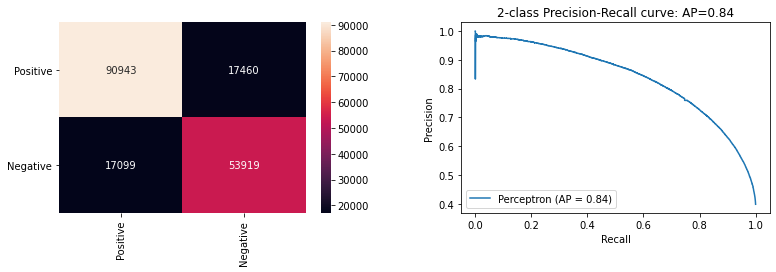

______________________________________________________________________________________________________________
MultinomialNB
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Score:  0.7355214829925149
Training time:  0.757544994354248
Validation time:  8.38425087928772


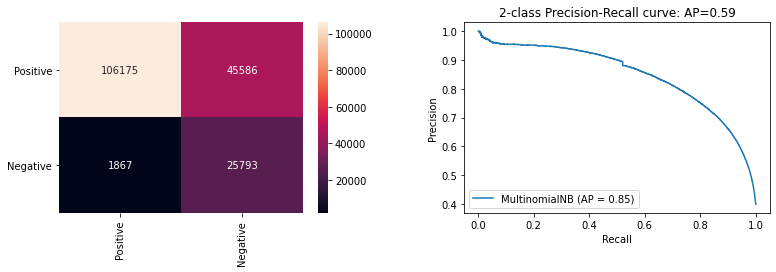

______________________________________________________________________________________________________________
LinearSVC
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 4000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Score:  0.8386309294898591
Training time:  19.808990955352783
Validation time:  8.303141832351685


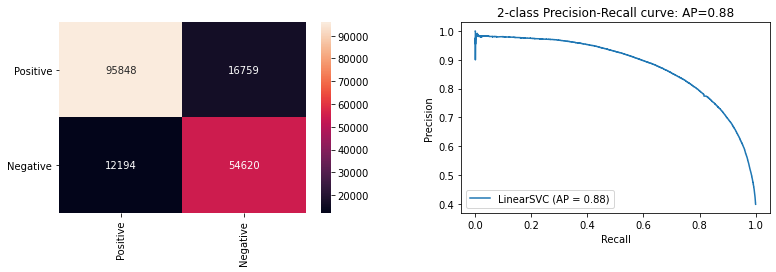

______________________________________________________________________________________________________________


In [ ]:
models = [Per, NB, SVC]
models_TFIDF, model_descriptions, scores, train_times, val_times = fit_models(X, X_test, y_test, vectorizer_TFIDF, models, True)

<b> Plotting and visualizing the results </b>

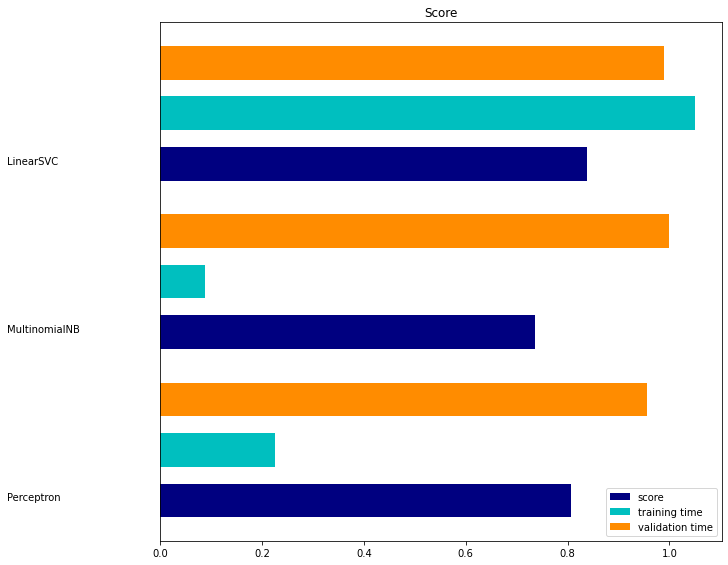

In [ ]:
draw_plots(models_TFIDF, model_descriptions, scores, train_times, val_times)

## **Deep Learning Models**

### **Bi-LSTM**

<b> Preparing the data - tokenization & padding </b>

In [ ]:
df = df.fillna("_na_")
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list(df['text']))

In [ ]:
tokens_corpus = pd.DataFrame()
tokens_corpus['text'] = df['text']
tokens_corpus['class'] = df['class']
tokens_corpus.text = tokenizer.texts_to_sequences(tokens_corpus.text)

In [ ]:
tokens_corpus['class'] = tokens_corpus['class'].astype(np.int)
tokens_corpus.head()

,text,class
0,"[3538, 6505, 2567]",0
1,"[1191, 21355]",0
3,"[6, 6290, 2736, 1656, 5436, 532, 9295, 501, 21...",0
4,"[121, 1, 2695, 39, 3983]",0
5,"[121, 16, 1, 206, 44, 41]",0


##### Helping functions

In [ ]:
def data_padding(target, by_col, maxlen):
    padded_data = pad_sequences(target[by_col], maxlen=maxlen, padding='post')
    target[by_col] = [seq for seq in padded_data]
    return target[by_col]

def create_data_arrays(data1, y):
    x1 = data1.copy()
    res1 = np.array(list(x for x in x1))
    y_arr = np.array(y)
    
    return res1, y_arr

# Help function for plotting the model training & validation loss and accuracy
def plot_model_results(model):
    fig, ax = plt.subplots(2,2,figsize=(25,18))
    # Plot training & validation loss values
    ax[0][0].plot(model.history['loss'])
    ax[0][0].plot(model.history['val_loss'])
    ax[0][0].set_title('Model loss')
    ax[0][0].set_ylabel('Loss')
    ax[0][0].set_xlabel('Epoch Amount')
    ax[0][0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    ax[0][1].plot(model.history['accuracy'])
    ax[0][1].plot(model.history['val_accuracy'])
    ax[0][1].set_title('Model accuracy')
    ax[0][1].set_ylabel('Accuracy')
    ax[0][1].set_xlabel('Epoch Amount')
    ax[0][1].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation MAE loss values
    ax[1][0].plot(model.history['mean_absolute_error'])
    ax[1][0].plot(model.history['val_mean_absolute_error'])
    ax[1][0].set_title('Model MAE Loss')
    ax[1][0].set_ylabel('MAE loss')
    ax[1][0].set_xlabel('Epoch Amount')
    ax[1][0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation MSE loss values
    ax[1][1].plot(model.history['mean_squared_error'])
    ax[1][1].plot(model.history['val_mean_squared_error'])
    ax[1][1].set_title('Model MSE Loss')
    ax[1][1].set_ylabel('MSE loss')
    ax[1][1].set_xlabel('Epoch Amount')
    ax[1][1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()
    
# Help function for display the confusion matrix to eavluate model performance
def model_con_matrix(y, results, labels):
    con = confusion_matrix(y,results)
    a = plt.figure(figsize=(20,15), dpi=50)
    a = sns.heatmap(con, annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
    a = plt.rcParams.update({'font.size': 20})
    a = plt.title('Confusion Matrix')
    a = plt.xlabel('Predictions')
    a = plt.ylabel('True Values')
    
def print_model_scores(history, name=""):
    print(f'=============== {name} Training Scores ===============')
    print(f'Model Average Training Accuracy: {np.mean(history.history["accuracy"])}')
    print(f'Model Average Training Loss: {np.mean(history.history["loss"])}')
    print(f'Model Average Training RMSE: {np.mean(history.history["mean_absolute_error"])}')
    print(f'Model Average Training MSE: {np.mean(history.history["mean_squared_error"])}')

    print(f'=============== {name} Validation Scores ===============')
    print(f'Model Average Validation Accuracy: {np.mean(history.history["val_accuracy"])}')
    print(f'Model Average Validation Loss: {np.mean(history.history["val_loss"])}')
    print(f'Model Average Validation RMSE: {np.mean(history.history["val_mean_absolute_error"])}')
    print(f'Model Average Validation MSE: {np.mean(history.history["val_mean_squared_error"])}')

In [ ]:
# Data padding according to the var maxlen
tokens_corpus.text = data_padding(tokens_corpus, by_col='text', maxlen=maxlen)
tokens_corpus.head()

,text,class
0,"[3538, 6505, 2567, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[1191, 21355, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[6, 6290, 2736, 1656, 5436, 532, 9295, 501, 21...",0
4,"[121, 1, 2695, 39, 3983, 0, 0, 0, 0, 0, 0, 0, ...",0
5,"[121, 16, 1, 206, 44, 41, 0, 0, 0, 0, 0, 0, 0,...",0


In [ ]:
# Creating train, validation and test sets
data_x_train_dl, data_x_test_dl, data_y_train_dl, data_y_test_dl = train_test_split(tokens_corpus['text'], tokens_corpus['class'], test_size = 0.2, random_state = 2021)
data_x_train_dl, data_x_val_dl, data_y_train_dl, data_y_val_dl = train_test_split(data_x_train_dl, data_y_train_dl, test_size=0.2)

print("X train shape: ", data_x_train_dl.shape, "y train shape: " , data_y_train_dl.shape)
print("X val shape: ", data_x_val_dl.shape, "y val shape: " , data_y_val_dl.shape)
print("X test shape: ", data_x_test_dl.shape, "y test shape: " , data_y_test_dl.shape)

X train shape:  (484544,) y train shape:  (484544,)
X val shape:  (121137,) y val shape:  (121137,)
X test shape:  (151421,) y test shape:  (151421,)


In [ ]:
# Orginizing the data into the right shapes
X_train_dl, y_train_dl = create_data_arrays(data_x_train_dl, data_y_train_dl)
X_val_dl, y_val_dl = create_data_arrays(data_x_val_dl, data_y_val_dl)
X_test_dl, y_test_dl = create_data_arrays(data_x_test_dl, data_y_test_dl)

print("X train shape: ", X_train_dl.shape, "y train shape: " , y_train_dl.shape)
print("X val shape: ", X_val_dl.shape, "y val shape: " , y_val_dl.shape)
print("X test shape: ", X_test_dl.shape, "y test shape: " , y_test_dl.shape)

X train shape:  (484544, 50) y train shape:  (484544,)
X val shape:  (121137, 50) y val shape:  (121137,)
X test shape:  (151421, 50) y test shape:  (151421,)


In [ ]:
# df = df.fillna("_na_")
# tokenizer = Tokenizer(num_words=max_features, lower=False)
# tokenizer.fit_on_texts(list(X_train))

# X_train = tokenizer.texts_to_sequences(X_train)
# X_train = pad_sequences(X_train, maxlen=maxlen)

#### Creating the Embedding Matrix from fasttext

In [ ]:
FT_PATH = 'F:\\SocialDynamics\\TrendsProject\\cc.he.300.bin'
ft = fasttext.load_model(FT_PATH)

<b> Customize the embedding matrix to our data </b>

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features+1, len(word_index))
embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in ft:
        embedding_vector = ft[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
np.save("F:\\SocialDynamics\\TrendsProject\\embeddings_20000.npy", embedding_matrix)

#### Loading Saved Embedding matrix

In [ ]:
embedding_matrix = np.load(path + "/embeddings_80000.npy")

#### Building Bi-LSTM Model

What have we constructed and why? First we created the input layer with the shape of (max length tweet, vocabulary size), then we added the embedding layer in size of 100 to create weights matrix for each word in the tweet's corpus in addition to the word2vec matrix that were injected to this layer, so those weights won't be trainable and keep their real distances weights.

Next we added Convolution 1D layer with kernel size of 3 to create more feature maps of the tweet's words. Afterwards we added 2 Bidirectional LSTM of size 256 that transfers weights from each double cells to all others and regularization of 40% dropout for each bi-lstm layer.

Finally we constructed 2 dense layers of 128 and 1 hidden neurons, the last dense layer of size 1 is with activation function of 'sigmoid' to produce the probability of being closer to 1 or 0 values.

The loss function is binary crossentropy since we are have only 2 classification [0,1] and the evaluation metrics we used are the accuracy, RMSE and MSE for getting more insights on the error rate/distance from our true labled data.



In [ ]:
def set_callbacks(model_name="1", patience=2):
    name = f'{path}/model_{model_name}_weights5.h5'
    cp = ModelCheckpoint(name, save_best_only=True)
    es = EarlyStopping(patience=patience*3, monitor='val_loss')
    rop = ReduceLROnPlateau(patience=patience)
    return [rop, es, cp]

In [ ]:
def init_model(inp_shape, voc_size, embedding_size=embed_size):
    
    inp = Input(shape=inp_shape)
    x = Embedding(max_features+1, embedding_size, input_length=maxlen, 
                  weights=[embedding_matrix], trainable=False)(inp)

    x = Conv1D(128,3, padding='same', activation='relu', name="Conv1D_1")(x)

    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4), name="BiLSTM_1")(x)

    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4), name="BiLSTM_2")(x)

    # x = LSTM(256, name="LSTM_1")(x)

    x = Dense(128, activation='relu', name="Dense_128")(x)
    x = Dense(1,activation='sigmoid', name="Output_Dense")(x)
    
    model = Model(inputs=inp,outputs=x)
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', MeanAbsoluteError(), MeanSquaredError()])
    
    return model

In [ ]:
max_features = 80_000
dl_model = init_model((maxlen,), voc_size=max_features)
dl_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           24000300  
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 50, 128)           115328    
_________________________________________________________________
BiLSTM_1 (Bidirectional)     (None, 50, 512)           788480    
_________________________________________________________________
BiLSTM_2 (Bidirectional)     (None, 50, 512)           1574912   
_________________________________________________________________
Dense_128 (Dense)            (None, 50, 128)           65664     
_________________________________________________________________
Output_Dense (Dense)         (None, 50, 1)             129 

#### Training the Bi-LSTM Model

In [ ]:
%%time
num_of_epochs = 50
batch_size = 128
history = dl_model.fit(X_train_dl,y_train_dl,
                        epochs=num_of_epochs,
                       batch_size=batch_size,
                       steps_per_epoch=X_train_dl.shape[0]/batch_size,
                       validation_data=(X_val_dl, y_val_dl),
                       validation_steps=X_val_dl.shape[0]/batch_size,
                       callbacks=set_callbacks(model_name="BiLSTM"))

dl_model.save(path + '/Models/Bi_LSTM_model_450users6.h5')

Epoch 1/50
3785/3785 [==============================] - 201s 53ms/step - loss: 0.6273 - accuracy: 0.6242 - mean_absolute_error: 0.4766 - mean_squared_error: 0.2386 - val_loss: 0.5415 - val_accuracy: 0.7068 - val_mean_absolute_error: 0.4376 - val_mean_squared_error: 0.2188
Epoch 2/50
3785/3785 [==============================] - 200s 53ms/step - loss: 0.5301 - accuracy: 0.7182 - mean_absolute_error: 0.4140 - mean_squared_error: 0.2069 - val_loss: 0.5027 - val_accuracy: 0.7380 - val_mean_absolute_error: 0.3971 - val_mean_squared_error: 0.1985
Epoch 3/50
3785/3785 [==============================] - 200s 53ms/step - loss: 0.4969 - accuracy: 0.7447 - mean_absolute_error: 0.3848 - mean_squared_error: 0.1923 - val_loss: 0.4839 - val_accuracy: 0.7528 - val_mean_absolute_error: 0.3752 - val_mean_squared_error: 0.1875
Epoch 4/50
3785/3785 [==============================] - 201s 53ms/step - loss: 0.4763 - accuracy: 0.7597 - mean_absolute_error: 0.3671 - mean_squared_error: 0.1835 - val_loss: 0.476

In [ ]:
import pickle
with open(path + '/ModelsHistory/trainHistoryDict_Bi_LSTM_model_450users6', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [ ]:
dl_model.load_weights(path + '/Models/Bi_LSTM_model_450users5.h6')

#### Training Results & Plots

In [ ]:
print_model_scores(history, name="BiLSTM DL Model")

=============== BiLSTM DL Model Training Scores ===============
Model Average Training Accuracy: 0.7909265129189742
Model Average Training Loss: 0.4249898242323022
Model Average Training RMSE: 0.3327316484953228
Model Average Training MSE: 0.1668785261480432
=============== BiLSTM DL Model Validation Scores ===============
Model Average Validation Accuracy: 0.7674347162246704
Model Average Validation Loss: 0.4675305658265164
Model Average Validation RMSE: 0.32698692773517807
Model Average Validation MSE: 0.1640324106341914


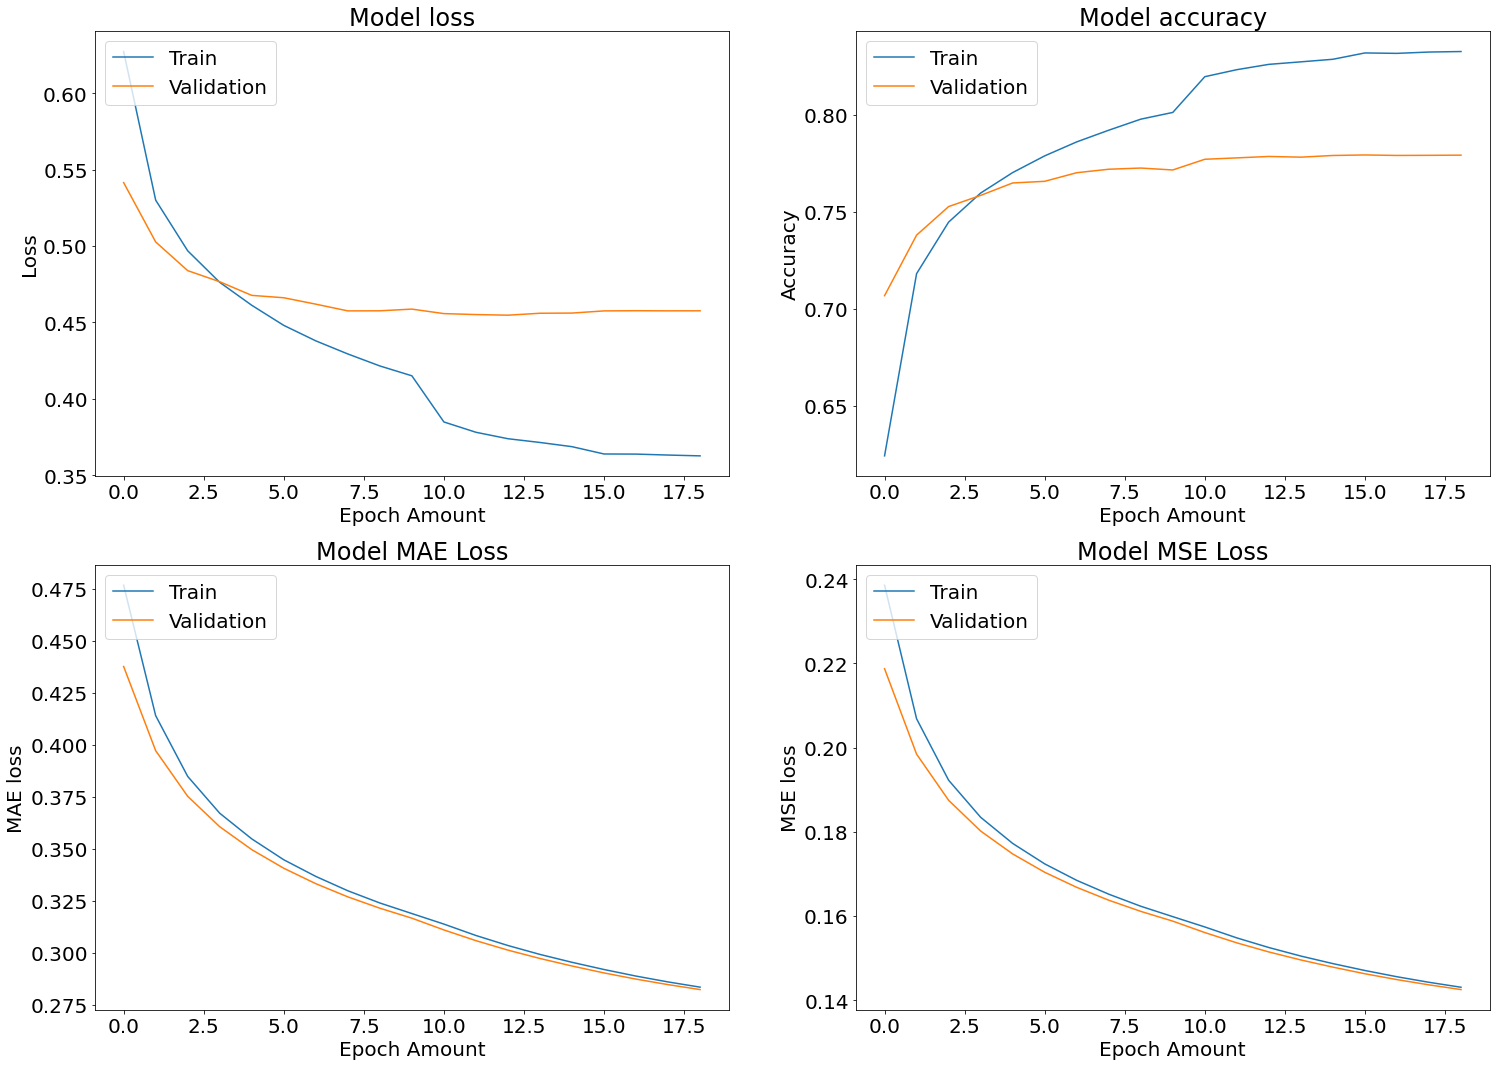

In [ ]:
plot_model_results(history)

#### Predictions & Results

In [ ]:
pred = dl_model.predict(X_test_dl)

In [ ]:
predictions = [pred[i][0] for i in range(len(pred))]
preds = [0 if p < 0.5 else 1 for p in predictions]

In [ ]:
print('model accuracy on test :',accuracy_score(y_test_dl,preds)*100)
print(classification_report(y_test_dl,preds))

model accuracy on test : 77.85313793991587
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     80400
           1       0.75      0.79      0.77     71021

    accuracy                           0.78    151421
   macro avg       0.78      0.78      0.78    151421
weighted avg       0.78      0.78      0.78    151421



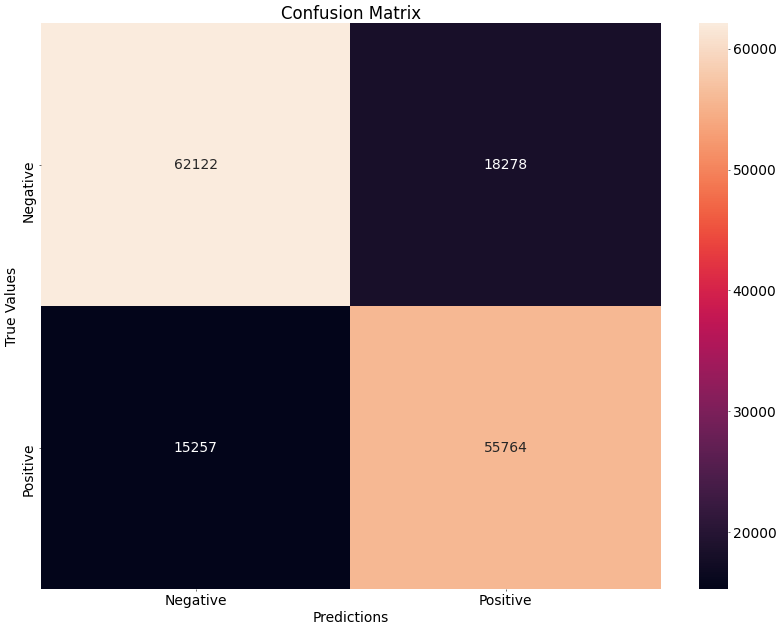

In [ ]:
model_con_matrix(y_test_dl, preds, ["Negative", "Positive"])

### **Classify Trends using DL model**

**Reading the trend tweets file**

In [ ]:
dir_path = path + '/Trends_Tweets.csv'
df_trends_to_classify = pd.read_csv(dir_path)

In [ ]:
# Reading the trends list
trends_text = []
with open(path + "/trends.txt", 'r', encoding='utf8') as f:
    trends_text = f.read().splitlines()
    
trends = []
for t in trends_text:
    t = t.split('\t')
    if len(t) < 3:
        trends.append(t[1])
    else:
        trends.append(t[2])

**Taking the 5 Trends with the most amount of tweets**

In [ ]:
df_trend1 = df_trends_to_classify[df_trends_to_classify['text'].str.contains('למה_גדעון_התפטר_ב2014')].reset_index()
df_trend2 = df_trends_to_classify[df_trends_to_classify['text'].str.contains('חוק יסוד')].reset_index()
df_trend3 = df_trends_to_classify[df_trends_to_classify['text'].str.contains('מורשת נתניהו')].reset_index()
df_trend4 = df_trends_to_classify[df_trends_to_classify['text'].str.contains('רק ביבי')].reset_index()
df_trend5 = df_trends_to_classify[df_trends_to_classify['text'].str.contains('של הפרקליטות')].reset_index()

df_trend1['Trend_name'] = ['למה_גדעון_התפטר_ב2014' for x in range(len(df_trend1))]
df_trend2['Trend_name'] = ['חוק יסוד' for x in range(len(df_trend2))]
df_trend3['Trend_name'] = ['מורשת נתניהו' for x in range(len(df_trend3))]
df_trend4['Trend_name'] = ['רק ביבי' for x in range(len(df_trend4))]
df_trend5['Trend_name'] = ['של הפרקליטות' for x in range(len(df_trend5))]

#Merging them together
df_5_trends = df_trend1
df_5_trends = ((((df_5_trends.append(df_trend2, ignore_index=True)).append(df_trend3, ignore_index=True)).append(df_trend4, ignore_index=True)).append(df_trend5, ignore_index=True))

In [ ]:
df_5_trends

,index,tweet_id,created_at,source,text,retweet_count,user_id,user_name,user_followers_count,user_friends_count,user_statuses_count,hashtags,reply_to_status_id_str,reply_to_user_id,Trend_name
0,0,1409768853308162052,2021-06-29 07:01:01,Twitter Web App,חברים : כל אחד שמצייץ .. נא להוסיף בסוף הציוץ ...,19.0,892778092200067072,להפסיק לבכות ולהתחיל להלחם - הייטקיסט בן 38 ימני,1920,3423,9522,"[{'text': 'למה_גדעון_התפטר_ב2014', 'indices': ...",NaN,NaN,למה_גדעון_התפטר_ב2014
1,1,1409769351385956352,2021-06-29 07:03:00,Twitter Web App,בוקר טוב לכולם !! #למה_גדעון_התפטר_ב2014,3.0,892778092200067072,להפסיק לבכות ולהתחיל להלחם - הייטקיסט בן 38 ימני,1920,3423,9522,"[{'text': 'למה_גדעון_התפטר_ב2014', 'indices': ...",NaN,NaN,למה_גדעון_התפטר_ב2014
2,2,1409769893176676352,2021-06-29 07:05:09,Twitter for iPhone,rt @bibist_hitech: בוקר טוב לכולם !! #למה_גדעו...,3.0,340325107,Yoav Frank האמת תנצח,3088,4140,15241,"[{'text': 'למה_גדעון_התפטר_ב2014', 'indices': ...",NaN,NaN,למה_גדעון_התפטר_ב2014
3,3,1409769934373150722,2021-06-29 07:05:19,Twitter for iPhone,rt @bibist_hitech: חברים : כל אחד שמצייץ .. נא...,19.0,340325107,Yoav Frank האמת תנצח,3088,4140,15241,"[{'text': 'למה_גדעון_התפטר_ב2014', 'indices': ...",NaN,NaN,למה_גדעון_התפטר_ב2014
4,4,1409770384556281859,2021-06-29 07:07:06,Twitter for iPhone,rt @bibist_hitech: חברים : כל אחד שמצייץ .. נא...,19.0,1105767815968108545,Edencohen,381,401,32312,"[{'text': 'למה_גדעון_התפטר_ב2014', 'indices': ...",NaN,NaN,למה_גדעון_התפטר_ב2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6332,49607,1418473092674957315,2021-07-23 07:28:33,Twitter for Android,@who_are_yoooo @tsur_ben 2020-11-29 אני מזדהה...,0.0,706107275203747840,שוקי משעול,2403,530,15077,[],1.418469e+18,2.269608e+08,של הפרקליטות
6333,49608,1418473232374673409,2021-07-23 07:29:07,Twitter Web App,@guygoldzwig @levyguy77 @drnirdagan 1) ביטול ה...,0.0,1243829763808075776,ThisAndThat,298,593,20016,[],1.418411e+18,1.207038e+18,של הפרקליטות
6334,49612,1418476135147581440,2021-07-23 07:40:39,Twitter Web App,@ynetalerts עושה דברה של הפרקליטות. עבד.,0.0,2521499466,Ori Lev,105,255,885,[],1.418458e+18,3.347385e+07,של הפרקליטות
6335,49620,1418490388885671936,2021-07-23 08:37:17,Twitter for iPhone,@aviadglickman @gidonsaar וקלדנית חלולה של הפר...,0.0,1288013422123274241,moshe kazan,102,147,1725,[],1.418490e+18,3.089415e+09,של הפרקליטות


**Preparing the trends data for our DL Model**

In [ ]:
#Punctuation removal
df_5_trends['text'] = df_5_trends['text'].apply(remove_punctuations)

In [ ]:
df_5_trends = df_5_trends.fillna("_na_")
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list(df_5_trends['text']))

In [ ]:
tokens_corpus = pd.DataFrame()
tokens_corpus['text'] = df_5_trends['text']
tokens_corpus.text = tokenizer.texts_to_sequences(tokens_corpus.text)

In [ ]:
# Data padding according to the var maxlen
tokens_corpus.text = data_padding(tokens_corpus, by_col='text', maxlen=maxlen)
tokens_corpus.head()

,text
0,"[144, 24, 54, 812, 793, 309, 422, 536, 35, 589..."
1,"[631, 133, 1506, 1, 2, 3, 4, 0, 0, 0, 0, 0, 0,..."
2,"[5, 44, 45, 631, 133, 1506, 1, 2, 3, 4, 0, 0, ..."
3,"[5, 44, 45, 144, 24, 54, 812, 793, 309, 422, 5..."
4,"[5, 44, 45, 144, 24, 54, 812, 793, 309, 422, 5..."


**Predicting political stance for each tweet**

In [ ]:
t_test = np.array(list(x for x in tokens_corpus['text'].values))
pred = dl_model.predict(t_test)

In [ ]:
predictions = [pred[i][0] for i in range(len(pred))]
preds = [0 if p < 0.5 else 1 for p in predictions]

In [ ]:
df_5_trends['Prediction'] = preds

**Plotting the results**

In [ ]:
df_trends_grouped_sum = df_5_trends.groupby(by='Trend_name')['Prediction'].sum()
df_trends_grouped_count = df_5_trends.groupby(by='Trend_name')['Prediction'].count()

In [ ]:
df_trends_right = df_trends_grouped_count-df_trends_grouped_sum
df_trends_left = df_trends_grouped_sum

In [ ]:
!pip install python-bidi
from bidi import algorithm as bidialg
y_labels = ['חוק יסוד', 'למה_גדעון_התפטר_ב2014', 'מורשת נתניהו', 'רק ביבי', 'של הפרקליטות']
y_labels = [bidialg.get_display(x) for x in y_labels]

In [ ]:
right_5_trends = df_trends_right.values
left_5_trends = df_trends_left.values

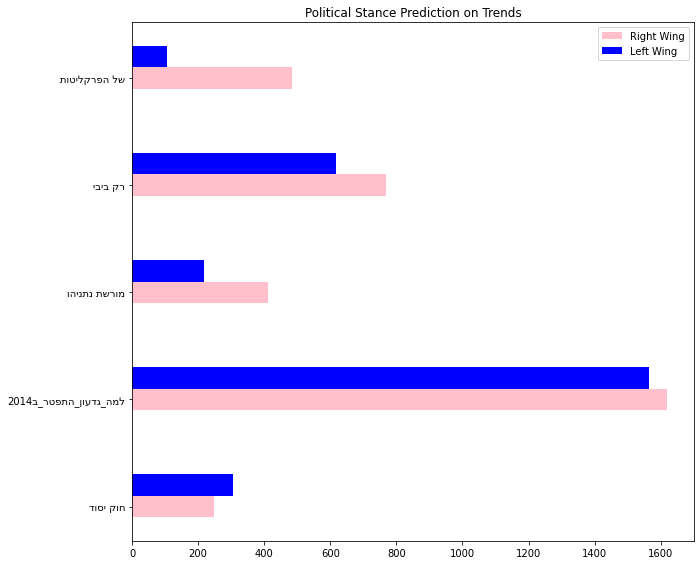

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Political Stance Prediction on Trends")
x = np.arange(len(right_5_trends))
plt.barh(x, right_5_trends, .2, label='Right Wing', color='pink')
plt.barh(x + .2, left_5_trends, .2, label='Left Wing', color='blue')
plt.yticks(x, y_labels)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

### **Classify Tweets of New Users**

**Reading the data**


In [ ]:
new_users_path = path + '/New_Users_Tweets.csv'
df_new_users = pd.read_csv(new_users_path)

**Preparing the data for our DL Model**

In [ ]:
df_new_users['text'] = df_new_users['text'].apply(remove_punctuations)

In [ ]:
df_new_users = df_new_users.fillna("_na_")
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list(df_new_users['text']))

In [ ]:
tokens_corpus_new_users = pd.DataFrame()
tokens_corpus_new_users['text'] = df_new_users['text']
tokens_corpus_new_users.text = tokenizer.texts_to_sequences(tokens_corpus_new_users.text)

In [ ]:
# Data padding according to the var maxlen
tokens_corpus_new_users.text = data_padding(tokens_corpus_new_users, by_col='text', maxlen=maxlen)
tokens_corpus_new_users.head()

,text
0,"[14230, 275, 95, 8, 3019, 17, 8716, 0, 0, 0, 0..."
1,"[14230, 275, 247, 4969, 14231, 8717, 1729, 33,..."
2,"[10727, 1542, 275, 2074, 94, 729, 4474, 1339, ..."
3,"[10731, 21466, 256, 21467, 21468, 730, 21469, ..."
4,"[10726, 10727, 1542, 275, 19, 1881, 21470, 553..."


**Predicting political stance for each tweet**

In [ ]:
new_users_test = np.array(list(x for x in tokens_corpus_new_users['text'].values))
pred = dl_model.predict(new_users_test)

In [ ]:
predictions = [pred[i][0] for i in range(len(pred))]
preds = [0 if p < 0.5 else 1 for p in predictions]

In [ ]:
df_new_users['Prediction'] = preds

**Plotting the results**

In [ ]:
df_pred_sum = df_new_users.groupby(by='user_name')['Prediction'].sum()
df_pred_count = df_new_users.groupby(by='user_name')['Prediction'].count()

In [ ]:
df_pred_right = df_pred_count-df_pred_sum
df_pred_left = df_pred_sum

In [ ]:
y_labels = [
'fridatuito',
'NadavMD1980',
'BtOsnat',
'SigalBagstevold',
'yossisoffer1',
'shimonco1',
'AdelDavid12',
'Miriambendavid',
'dsO5lr112iEHL4o-Daniel',
'VBbZCYJbsobJtIJ-HaimLevi']

In [ ]:
right_new_users = df_pred_right.values
left_new_users = df_pred_left.values

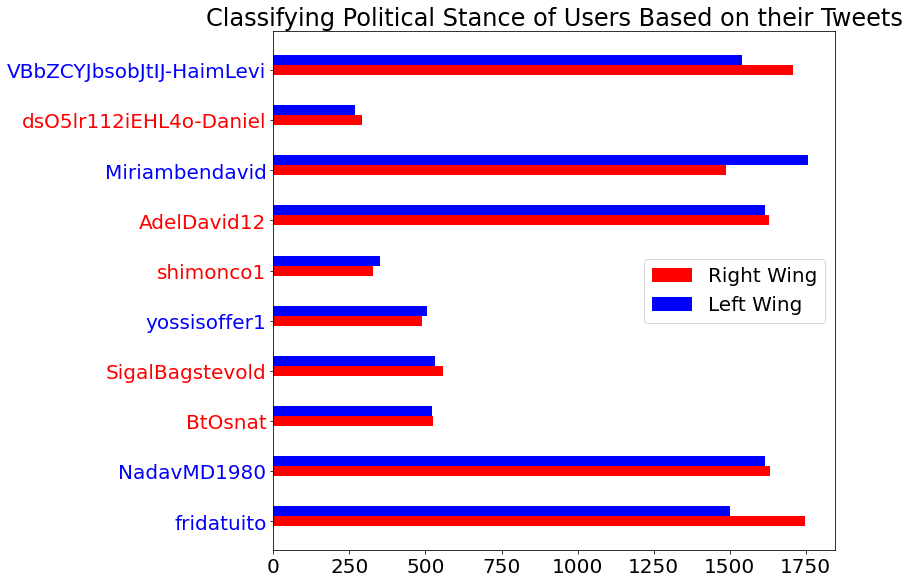

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Classifying Political Stance of Users Based on their Tweets")
x = np.arange(len(right_new_users))
plt.barh(x, right_new_users, .2, label='Right Wing', color='red')
plt.barh(x + .2, left_new_users, .2, label='Left Wing', color='blue')
plt.yticks(x, y_labels, color="red")
plt.gca().get_yticklabels()[0].set_color("blue")
plt.gca().get_yticklabels()[1].set_color("blue")
plt.gca().get_yticklabels()[4].set_color("blue")
plt.gca().get_yticklabels()[7].set_color("blue")
plt.gca().get_yticklabels()[9].set_color("blue")
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

### <b> Building the BERT model </b>

In [ ]:
df_t = df[df['class'] == 0]
df_t2 = df[df['class'] == 1]

df_t = df_t.sample(100_000)
df_t2 = df_t2.sample(100_000)
df_100_000 = df_t.append(df_t2)
df_rest = pd.concat([df, df_100_000, df_100_000]).drop_duplicates(keep=False)

df_100_000.to_csv(path + '/bert_samples_100000.csv', index = False, header = True)
df_rest.to_csv(path + '/bert_rest_data.csv', index=False, header=True)

df = df_100_000

print(df['class'].value_counts())
_ = plt.figure(figsize=(3,3))
_ = plt.bar(x=['Positive', 'Negative'], height=df['class'].value_counts(), width=0.4)
plt.show()

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
# specify GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
df = pd.read_csv(path+'/bert_rest_data.csv')

In [ ]:
# NA Values
df = df.drop([df.index[81365], df.index[81366]])

In [ ]:
df['class'] = df['class'].astype(np.int)

In [ ]:
df = df.fillna("_na_")
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['class'], 
                                                                    random_state=2021, 
                                                                    test_size=0.3, 
                                                                    stratify=df['class'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# del train_text, temp_text, train_labels, temp_labels, val_text, val_labels
df = df.fillna("_na_")
test_text = df['text']
test_labels = df['class']

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

#tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

#### Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

#### Create DataLoaders

In [ ]:

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

#### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

#### Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

#### <b> Training the model </b>

In [ ]:
# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
        #       elapsed = format_time(time.time() - t0)

          # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
t_path = path + '/Models/BERT_saved_weights2.pt'

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), t_path)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

#### Load Saved Model

In [ ]:
#load weights of best model
path = path + '/Models/BERT_saved_weights2.pt'
model.load_state_dict(torch.load(path))

In [ ]:
len(test_seq)

#### <b> Testing the model </b>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq[:8_000].to(device), test_mask[:8_000].to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)